# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from math import factorial
from scipy import stats as st
from tqdm.notebook import tqdm
import math

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Общая информация**
1. В датасете 11 559 уникальных игр для 31 платформы.
2. Данные собраны за 37 лет, с 1980 по 2016.
3. Игры разделены на 12 жанров.
4. Есть данные о продажах в Северной Америке, Европе, Японии и суммарно по другим странам.
5. Есть оценки критиков (максимум 100) и оценки пользователей (максимум 10) по некоторым играм.
6. По большинству игр, выпущенных после 2000 года, есть информация о рейтинге ESRB.

## Предобработка данных

**Приводим названия столбцов к нижнему регистру.**

In [5]:
df.columns.str.lower()

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Также переименуем колонку Year_of_Release для удобства

In [6]:
df.columns = ['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

**Изучаем пропуски в данных.**

In [7]:
df_isnull = df.isnull().sum().to_frame(name = 'Количество пропусков')
df_isnull['Процент пропусков'] = df.isna().mean()*100
df_isnull.sort_values(by=['Процент пропусков'],ascending=False).head(6)

,Количество пропусков,Процент пропусков
critic_score,8578,51.319174
rating,6766,40.478612
user_score,6701,40.089740
year,269,1.609333
name,2,0.011965
genre,2,0.011965


**Удаляем строки с пропущенными значениями name, genre и year.**

Пропуски name и genre в одних и тех же строках:

In [8]:
df = df.dropna(subset = ['name']).reset_index(drop=True)

Пропущенные значения year это 1,6% от пропусков в своем столбце и 1% от всех суммарных продаж. Удаляем строки, так как адекватной замены нет, а данные с пропусками в дальнейшем все равно не попадут в изучаемую выборку. 

In [9]:
df = df.dropna(subset = ['year']).reset_index(drop=True)

Во всех остальных колонках оставляем пропуски, так как адекватного способа замены нет.

**Убираем значения tbd в колонке user_score, так как по сути это пропущенные значения.**

In [10]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

**Изменение типов данных.**

In [11]:
#df['year'] = pd.to_datetime(df['year'], format='%Y')

In [12]:
df = df.astype({'user_score': 'float', 'year': 'int'})

**Поиск дубликатов.**

In [13]:
df.duplicated().sum()

0

**Добавляем колонку с общими продажами**

In [14]:
df['global_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

## EDA

**Посмотрим, сколько игр выпускалось в разные годы.**

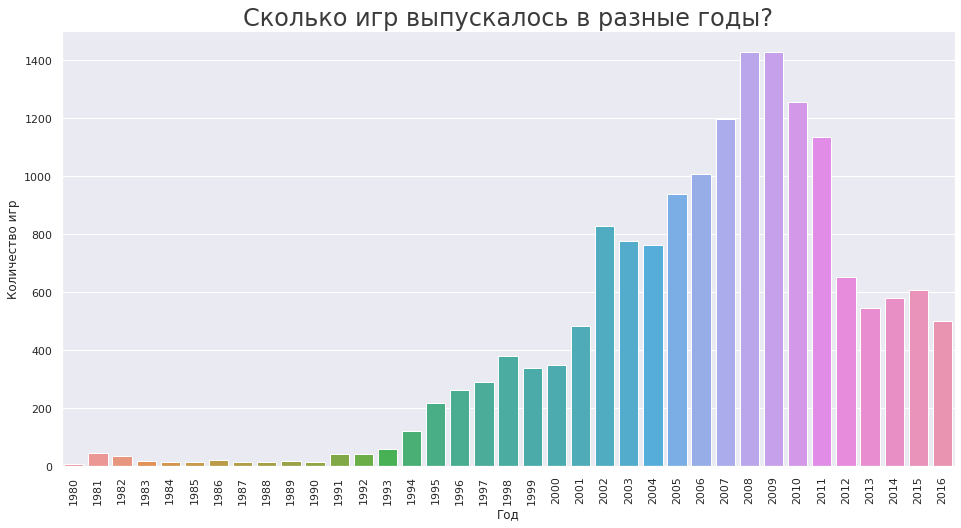

In [15]:
plt.figure(figsize=(16,8))
sns.countplot(data = df, x='year')
plt.xticks(rotation='vertical')
plt.title('Сколько игр выпускалось в разные годы?', fontsize = 24, alpha = 0.9)
plt.xlabel('Год')
plt.ylabel('Количество игр');

Больше всего игр было выпущено в 2007-2008 годах. Затем количество игровых релизов постепенно снизилось в среднем до 600 игр в год, в период с 2011 по 2016. Скорее всего это связано с начавшейся в 10х годах жёсткой конкуренцией со стороны смартфонов, планшетных компьютеров и смарт-телевизоров. Очевидно, что важны данные не за весь период с 1985 года, но чтобы выделить актуальный период необходимо детальнее исследовать продажи по различным платформам.

**Посмотрим, как менялись продажи по платформам.**

Удалим 1985 год у платформы DS(1 строка), так как это ошибка, потому что платформы DS еще не было в 1985 году.

In [16]:
df = df.drop(index=[15704]).reset_index(drop=True)

В датасете есть платформы, для которых было выпущено менее 20 игр за весь период. Исключим их из исследования. 

In [17]:
df.pivot_table(index=['platform'],
               values=['name'],
               aggfunc='count').sort_values(by=['name'],ascending=False).tail(7)

,name
platform,
NG,12
SCD,6
WS,6
3DO,3
TG16,2
PCFX,1
GG,1


In [18]:
popular_platforms = df.pivot_table(index=['platform'],
                                     values=['name'],
                                     aggfunc='count').sort_values(by=['name'],ascending=False).head(24).reset_index()
df = df.merge(popular_platforms['platform'], on=['platform'], how = 'inner')

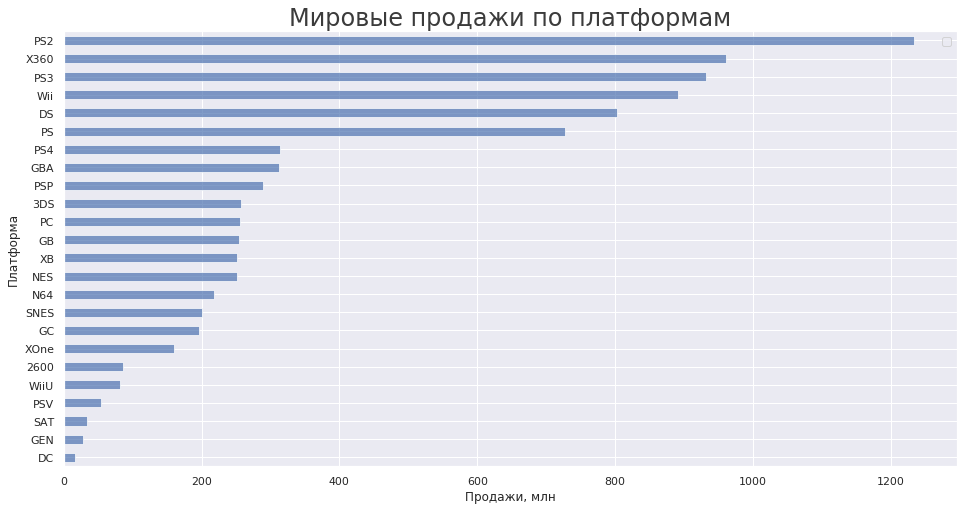

In [19]:
df.pivot_table(index=['platform'],
                   values=['global_sales'],
                   aggfunc=sum).sort_values(by=['global_sales'],ascending=True)\
.plot(kind='barh', figsize=(16,8), grid = True, alpha = 0.7)
plt.title('Мировые продажи по платформам', fontsize = 24, alpha = 0.9)
plt.xlabel('Продажи, млн')
plt.ylabel('Платформа')
plt.legend('');

Изучим жизненный цикл платформ на примере Топ-6 платформ по мировым продажам игр.
1. PS2 (Sony)
2. X360 (Microsoft)
3. PS3 (Sony)
4. Wii (Nintendo)
5. DS (Nintendo)
6. PS (Sony)

In [20]:
top_6_platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


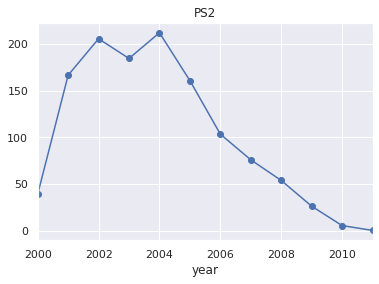

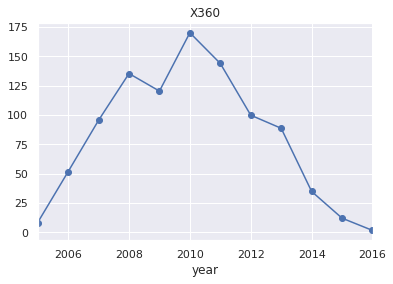

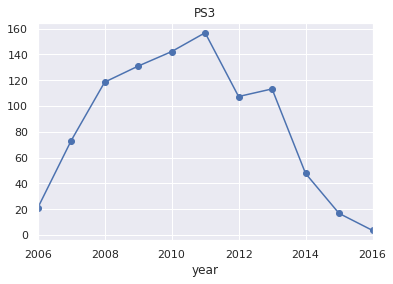

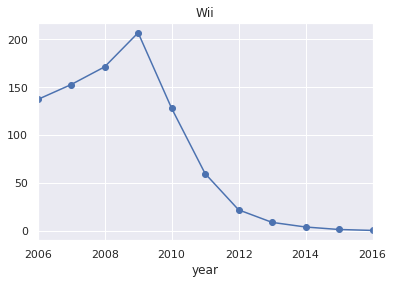

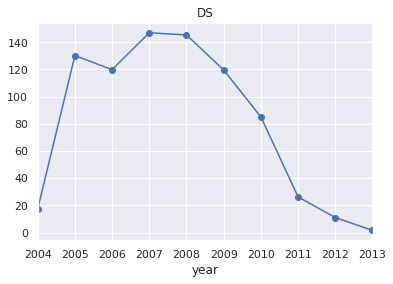

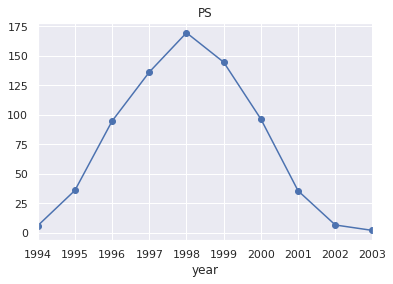

In [21]:
for row in top_6_platform:
    print(df[df['platform'] == row].pivot_table(index=['year'], 
                                    columns=['platform'],
                                    values=['global_sales'],
                                    aggfunc=sum).plot(title = row, legend = False, marker='o'))

У каждой платформы четко видны стадии: рост продаж, пик и постепенный спад. Лидером по продажам за всю историю является PS2. Но продажи к 2011 году уже нулевые. X360 был на пике в 2010, но к 2016 упал почти до 0. В целом резкий спад платформы может произойти буквально за 3 года, так как на рынке появляются новые игровые платформы.

В истории игровой индустрии выделяют 8 поколений игровых приставок. Сгруппируем 24 платформы по принадлежности к определенному поколению и посмотрим на динамику продаж. Персональные компьютеры выделим в отдельную категорию.
1. II поколение (1976 - 1983)
2. III поколение (1985 - 1990)
3. IV поколение (1987 - 1994)
4. V поколение (1993 - 1999)
5. VI поколение (1999 - 2003)
6. VII поколение (2004 - 2011)
7. VIII поколение (2004 - наст.время*)
8. PC 

*2016 год

In [22]:
def platform_category(row):
    if row['platform'] in '2600':
        return 'II'
    if row['platform'] in 'NES':
        return 'III'
    if row['platform'] in ('GEN','GB','SNES'):
        return 'IV'
    if row['platform'] in ('SAT','N64','PS'):
        return 'V'
    if row['platform'] in ('DC','GC','XB','GBA','PS2'):
        return 'VI'
    if row['platform'] in ('PSP','X360','Wii','PS3','DS'):
        return 'VII'
    if row['platform'] in ('WiiU','XOne','PS4', 'PSV', '3DS'):
        return 'VIII'
    return 'PC'

df['platform_category'] = df.apply(platform_category, axis = 1)

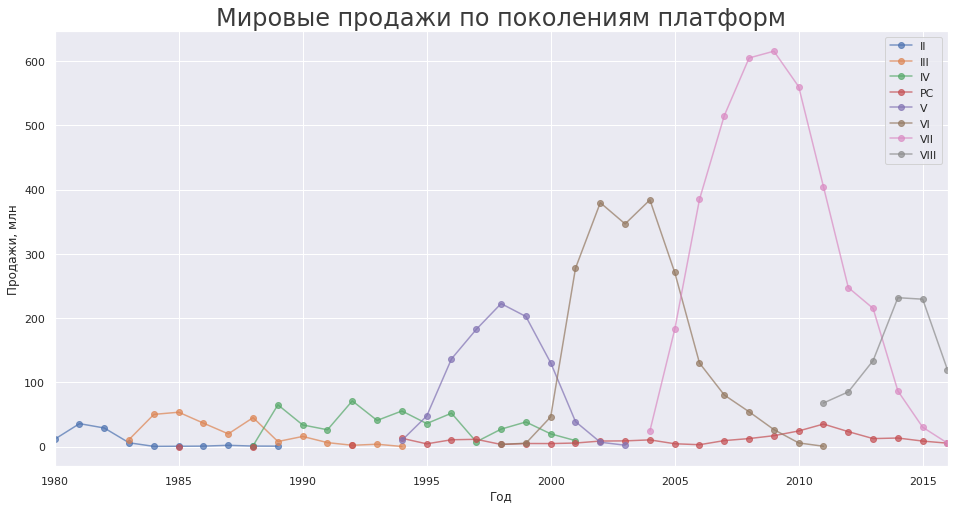

In [23]:
df.pivot_table(index=['year'],
               columns=['platform_category'],
               values=['global_sales'],
               aggfunc=sum)\
.plot(figsize=(16,8), grid = True, alpha = 0.7, marker ='o')
plt.title('Мировые продажи по поколениям платформ', fontsize = 24, alpha = 0.9)
plt.xlabel('Год')
plt.ylabel('Продажи, млн')
plt.legend(['II', 'III', 'IV', 'PC', 'V', 'VI', 'VII', 'VIII',]);

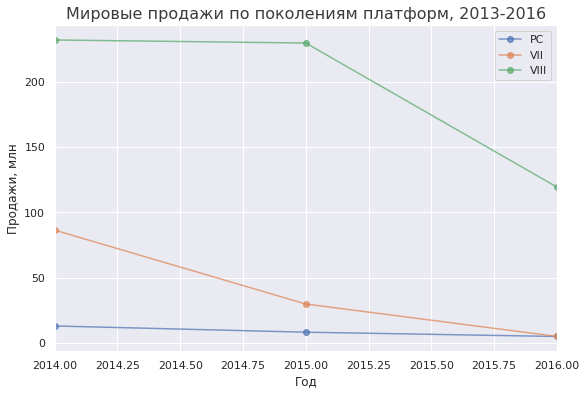

In [24]:
df[df['year'] >= 2014].pivot_table(index=['year'],
               columns=['platform_category'],
               values=['global_sales'],
               aggfunc=sum)\
.plot(figsize=(9,6), grid = True, alpha = 0.7, marker ='o')
plt.title('Мировые продажи по поколениям платформ, 2013-2016', fontsize = 16, alpha = 0.9)
plt.xlabel('Год')
plt.ylabel('Продажи, млн')
plt.legend(['PC', 'VII', 'VIII']);

- На графиках четко видно: когда начинается рост продаж для нового поколения платформ, продажи предыдущего поколения начинают падать.  
- Данные по продажам за 2016 год неполные, это объясняет почему для 8 поколения продажи за 2016 год ниже, чем за 2015. Учитывая динамику предыдущих лет, 8 поколение игровых приставок в стадии роста.  
- Отдельную нишу занимает ПК, сохраняя почти одинаковый показатель продаж с 1994 года.  
- В 2014 продажи 8 поколения превысили продажи 7, и начался новый цикл в индустрии. Судя по историческим данным, игры для 8 поколения платформ в ближайшее время будут основным источником прибыли, при этом 7 поколение и игры для ПК также будут занимать некоторую долю рынка.

**За актуальный период возьмем 3 года, 2014, 2015 и 2016. Остальные периоды не будем учитывать в исследовании.**

In [25]:
df_old = df

In [26]:
df = df[df['year'] >= 2014].reset_index(drop=True)

**Посмотрим какие платформы лидируют по продажам**

In [27]:
df.pivot_table(index=['platform', 'platform_category'],
               values=['global_sales'],
               aggfunc=sum).sort_values(by=['global_sales'],ascending=False).reset_index()

,platform,platform_category,global_sales
0,PS4,VIII,288.15
1,XOne,VIII,140.36
2,3DS,VIII,86.68
3,PS3,VII,68.18
4,X360,VII,48.22
5,WiiU,VIII,42.98
6,PC,PC,27.05
7,PSV,VIII,22.40
8,Wii,VII,5.07
9,PSP,VII,0.36


Топ-3 по продажам: домашние консоли PS4 и XOne, и портативная 3DS.

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


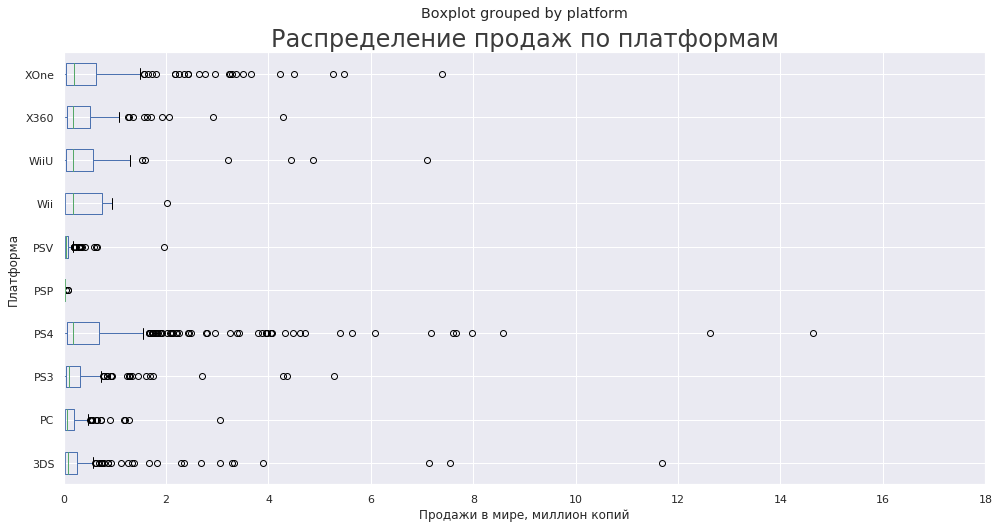

In [28]:
df.boxplot('global_sales', by='platform', figsize=(16,8), vert=False)
plt.xlim(0,18)
plt.title('Распределение продаж по платформам', fontsize = 24, alpha = 0.9)
plt.xlabel('Продажи в мире, миллион копий')
plt.ylabel('Платформа');

В датасете за актуальный период 956 уникальных игр.  
Как видно из графика, у каждой платформы есть 'звезды' среди всех игр. Скорее всего, здесь будет работать правило Парето и как раз эти 'выбросы' будут приносить большую часть прибыли. Здесь можно было бы провести более детальное исследование.

**Посмотрим, как влияют на продажи отзывы пользователей и критиков.**

Для исследования выберем абсолютного лидера по продажам - PS4.

In [29]:
PS4 = df[df['platform'] == 'PS4'].reset_index(drop=True)

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

In [30]:
print(PS4['global_sales'].corr(PS4['critic_score']))
print('Корреляция между продажами и рейтингом критиков есть, но не сильная')

0.40266141068104083
Корреляция между продажами и рейтингом критиков есть, но не сильная


In [31]:
print(PS4['global_sales'].corr(PS4['user_score']))
print('Корреляции между продажами и рейтингом пользователей нет')

-0.040131589472697356
Корреляции между продажами и рейтингом пользователей нет


In [32]:
print(PS4['user_score'].corr(PS4['critic_score']))
print('Корреляция между прейтингом пользователей и рейтингом критиков есть, но не сильная')

0.546434245119031
Корреляция между прейтингом пользователей и рейтингом критиков есть, но не сильная


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


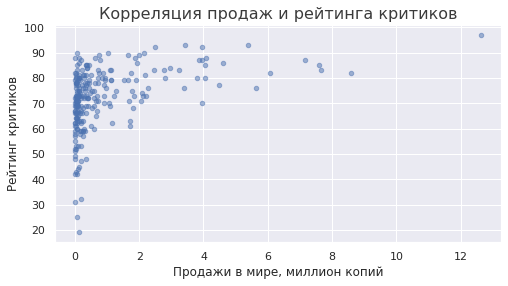

In [33]:
PS4.plot(x='global_sales', y='critic_score', kind='scatter', alpha=0.5, figsize=(8,4))
plt.title('Корреляция продаж и рейтинга критиков', fontsize = 16, alpha = 0.9)
plt.xlabel('Продажи в мире, миллион копий')
plt.ylabel('Рейтинг критиков');

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


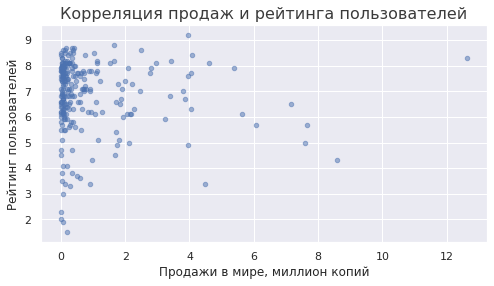

In [34]:
PS4.plot(x='global_sales', y='user_score', kind='scatter', alpha=0.5, figsize=(8,4))
plt.title('Корреляция продаж и рейтинга пользователей', fontsize = 16, alpha = 0.9)
plt.xlabel('Продажи в мире, миллион копий')
plt.ylabel('Рейтинг пользователей');

Некоторая зависимость между показателями есть, но не сильная. Можно сделать вывод, что на продажи влияют и другие факторы. Возможно, что новые игры покупают из-за популярности предыдущих частей, но в целом они получают низкий рейтинг. Также стоит подробнее исследовать игры с высоким рейтингом и низкими продажами, скорее всего там есть игры с хорошим потенциалом роста. 

**Распределение игр по жанрам.**

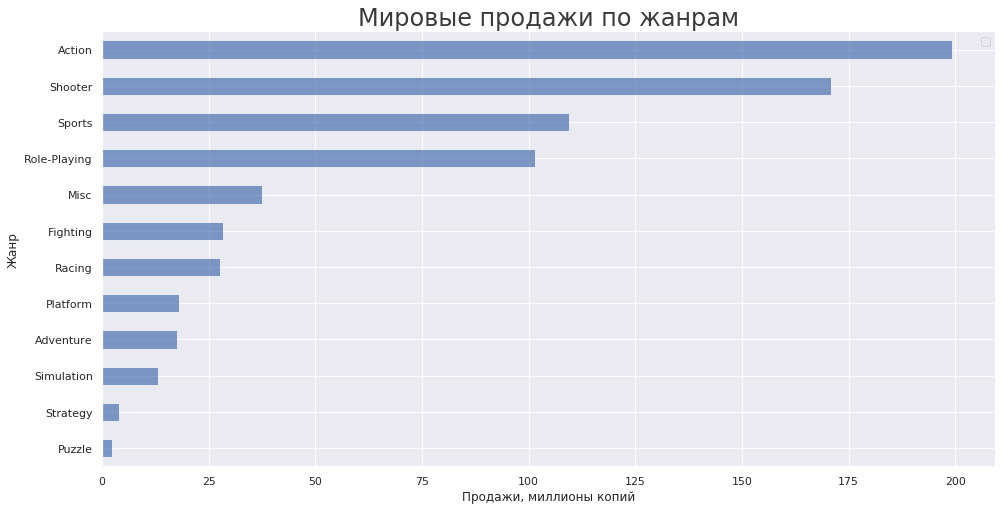

In [35]:
df.pivot_table(index=['genre'],
               values=['global_sales'],
               aggfunc=sum).sort_values(by=['global_sales'],ascending=True)\
.plot(kind='barh', figsize=(16,8), grid = True, alpha = 0.7)
plt.title('Мировые продажи по жанрам', fontsize = 24, alpha = 0.9)
plt.xlabel('Продажи, миллионы копий')
plt.ylabel('Жанр')
plt.legend('');

Топ-3 жанров: Action, Shooter, Sports.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


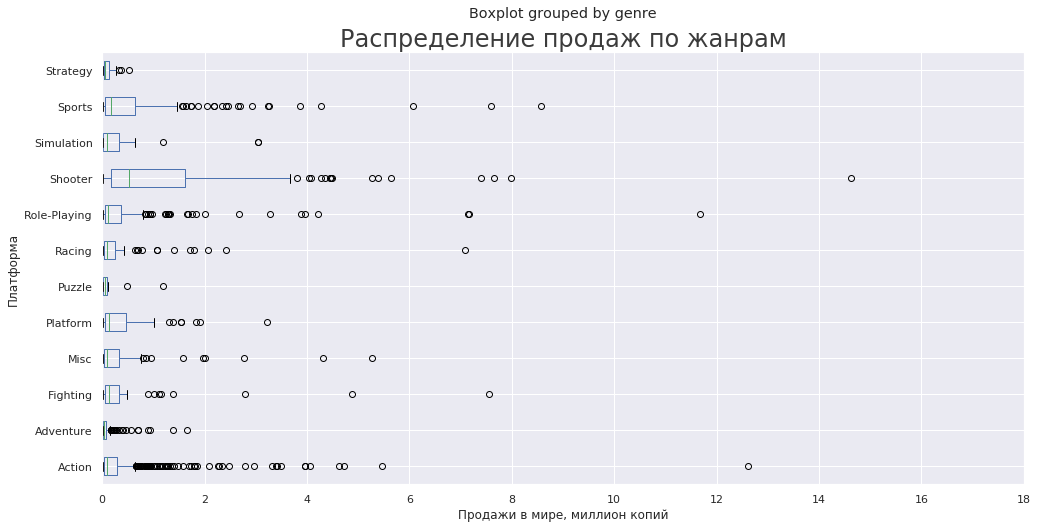

In [36]:
df.boxplot('global_sales', by='genre', figsize=(16,8), vert=False)
plt.xlim(0,18)
plt.title('Распределение продаж по жанрам', fontsize = 24, alpha = 0.9)
plt.xlabel('Продажи в мире, миллион копий')
plt.ylabel('Платформа');

In [37]:
df.pivot_table(index=['genre'],
               values=['name','global_sales'],
               aggfunc={'name':'count',
                        'global_sales':[np.sum, np.median]})

global_sales          name
                   median     sum count
genre                                  
Action              0.090  199.36   619
Adventure           0.030   17.55   185
Fighting            0.125   28.22    60
Misc                0.090   37.55   113
Platform            0.140   18.09    38
Puzzle              0.045    2.21    14
Racing              0.090   27.52    69
Role-Playing        0.110  101.44   221
Shooter             0.515  170.94   128
Simulation          0.100   13.13    44
Sports              0.180  109.48   161
Strategy            0.060    3.96    37

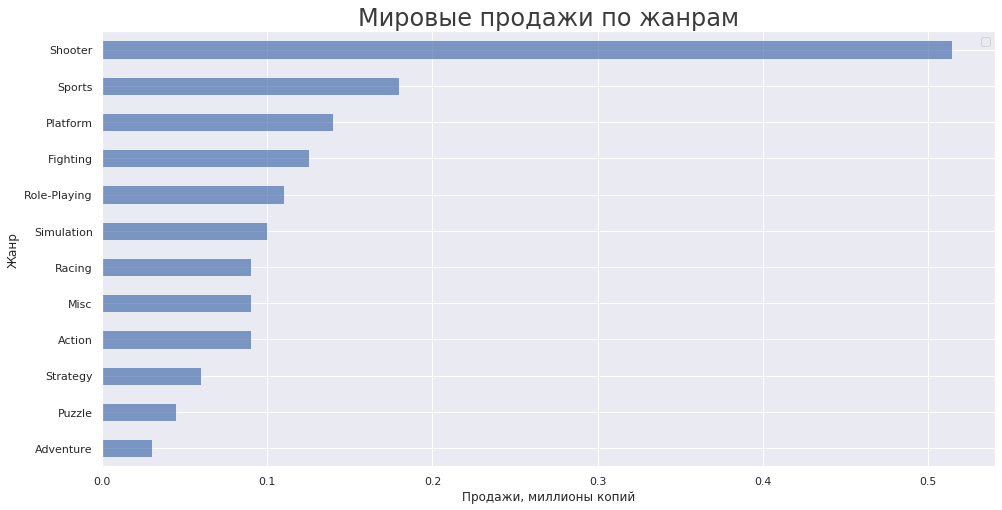

In [58]:
df.pivot_table(index=['genre'],
               values=['global_sales'],
               aggfunc=np.median).sort_values(by=['global_sales'],ascending=True)\
.plot(kind='barh', figsize=(16,8), grid = True, alpha = 0.7)
plt.title('Мировые продажи по жанрам', fontsize = 24, alpha = 0.9)
plt.xlabel('Продажи, миллионы копий')
plt.ylabel('Жанр')
plt.legend('');

По объему продаж лидирует жанр Action, но как видно из сводной таблицы это происходит из-за большого количества выпускаемых игр, а также из-за большого количества бестселлеров. Если посмотреть на медианные продажи, лидирует жанр Shooter.

## Портрет пользователя

**Самые популярные платформы (топ-5)**

In [39]:
area = ['na_sales', 'eu_sales', 'jp_sales']

In [40]:
for row in area:
    print(df.pivot_table(index=['platform'],\
               values=[row],\
               aggfunc=sum).sort_values(by=[row],ascending=False).head(5).reset_index())
    print('====================')

  platform  na_sales
0      PS4     98.61
1     XOne     81.27
2     X360     28.30
3      3DS     22.64
4      PS3     22.05
  platform  eu_sales
0      PS4    130.04
1     XOne     46.25
2      PS3     25.54
3       PC     17.97
4      3DS     16.12
  platform  jp_sales
0      3DS     44.24
1      PS4     15.02
2      PSV     14.54
3      PS3     11.22
4     WiiU      7.31


Популярность платформы зависит от влиния производителя в каждом регионе.  
В Европе и Америке лидирует PS4 от Sony.  
В Америке XOne от Microsoft успешно конкурирует с Sony и занимает около половины доли рынка.
В Японии конкурируют Nintendo и Sony. В Японии абсолютный лидер по продажам - 3DS от Nintendo, но за пределами Японии продукты Nintendo менее популярны, чем Sony. В Японии в топ-5 присутствует портативная PSV, в остальных регионах в топ-5 попали только домашние консоли.

**Самые популярные жанры (топ-5)**

In [41]:
for row in area:
    print(df.pivot_table(index=['genre'],\
               values=[row],\
               aggfunc=sum).sort_values(by=[row],ascending=False).head(5).reset_index())
    print('=========================')

          genre  na_sales
0       Shooter     79.02
1        Action     72.53
2        Sports     46.13
3  Role-Playing     33.47
4          Misc     15.05
          genre  eu_sales
0        Action     74.68
1       Shooter     65.52
2        Sports     45.73
3  Role-Playing     28.17
4        Racing     14.13
          genre  jp_sales
0  Role-Playing     31.16
1        Action     29.58
2      Fighting      6.37
3          Misc      5.61
4       Shooter      4.87


У амеркансих и европейских игроков в целом одинаковые предпочтения по жанрам, они любят жанры Action, Shooter и Sports.  
Японские предпочитают более многообразные RPG.  
Жанр Action популярен во всем мире.

**Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

**E** - («Everyone») — «Для всех».  
**E10+** - «Для всех старше 10 лет».  
**T** - («Teen») — «Подросткам 13—19 лет».  
**M** - («Mature») — «От 17 лет».  
**Other** - игры без рейтинга ESRB.

In [43]:
df['rating'] = df['rating'].fillna('Other')

In [56]:
for row in area:
    print(df.pivot_table(index=['rating'],\
               values=[row],\
               aggfunc=sum).sort_values(by=[row],ascending=False))
    print('================')

        na_sales
rating          
M          96.42
Other      64.72
E          50.74
T          38.95
E10+       33.23
        eu_sales
rating          
M          93.44
Other      58.95
E          58.06
T          34.07
E10+       26.16
        jp_sales
rating          
Other      56.90
T          14.78
E           8.94
M           8.01
E10+        4.46


В Америке и Европе большую часть от объема продаж занимают игры с рейтингом M. Как видно, в Японии ESRB почти не применяется, так как в этой стране действует собственная система рейтинга CERO.

## Проверка гипотез

### Исследование пользовательских рейтингов платформ Xbox One и PC

H0 = Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
H1 = Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Формируем два массива для проверки гипотезы:

In [45]:
xbox_score = df.query('platform == "XOne"')['user_score']
pc_score = df.query('platform == "PC"')['user_score']

Задаем уровень статистической значимости. Если p-value окажется меньше него - отвергнем гипотезу:

In [46]:
alpha1 = 0.05

Проверяем гипотезу:

In [47]:
res1 = st.ttest_ind(xbox_score, pc_score, equal_var=False, nan_policy='omit')

In [48]:
print('p-значение:', res1.pvalue)
if res1.pvalue < alpha1:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.11601398086668985
Не получилось отвергнуть нулевую гипотезу


In [49]:
print(xbox_score.mean())
print(pc_score.mean())

6.594545454545454
6.298360655737704


**Вывод**  
 Средние пользовательские рейтинги платформ Xbox One и PC практически не различаются.  
 А это различие со значительной вероятностью случайно.

### Исследование пользовательских рейтингов жанров Action и Sports 

H0 = Средние пользовательские рейтинги жанров Action и Sports одинаковые.  
H1 = Средние пользовательские рейтинги жанров Action и Sports различаются.

Формируем два массива для проверки гипотезы:

In [50]:
action_score = df.query('genre == "Action"')['user_score']
sports_score = df.query('genre == "Sports"')['user_score']

Задаем уровень статистической значимости. Если p-value окажется меньше него - отвергнем гипотезу:

In [51]:
alpha2 = 0.05

Проверяем гипотезу:

In [52]:
res2 = st.ttest_ind(action_score, sports_score, equal_var=False, nan_policy='omit')

In [53]:
print('p-значение:', res2.pvalue)
if res2.pvalue < alpha2:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.1825550382644845e-14
Отвергаем нулевую гипотезу


In [54]:
print(action_score.mean())
print(sports_score.mean())

6.760606060606061
5.225196850393701


**Вывод**  
 Средние пользовательские рейтинги жанров Action и Sports различаются.   
Проверив гипотезы, можно сделать вывод, что это не случайно. Видимо, пользователи больше любят игры в жанре Action. 

## Общий вывод


**Исследовательский анализ**  
- Больше всего игр было выпущено в 2007-2008 годах. Затем количество игровых релизов постепенно снизилось в среднем до 600 игр в год, в период с 2011 по 2016. Это связано с начавшейся в 10х годах жёсткой конкуренцией со стороны смартфонов, планшетных компьютеров и смарт-телевизоров. 
- Каждая платформа проходит через стадии: рост продаж, пик и постепенный спад. Лидером по продажам за всю историю является PS2. В целом резкий спад платформы может произойти буквально за 3 года, так как на рынке появляются новые игровые платформы.
- Когда начинается рост продаж для нового поколения платформ, продажи предыдущего поколения начинают падать.  
- 8 поколение игровых приставок в стадии роста.
- В 2014 продажи 8 поколения превысили продажи 7, и начался новый цикл в индустрии. Судя по историческим данным, игры для 8 поколения платформ в ближайшее время будут основным источником прибыли, при этом 7 поколение и игры для ПК также будут занимать некоторую долю рынка.
- У каждой платформы есть 'звезды' среди всех игр. Скорее всего, здесь будет работать правило Парето и как раз эти 'выбросы' будут приносить большую часть прибыли.
- Между рейтингом и продажами есть некоторая зависимость, но не сильная. Можно сделать вывод, что на продажи влияют и другие факторы. Также стоит подробнее исследовать игры с высоким рейтингом и низкими продажами, скорее всего там есть игры с хорошим потенциалом роста. 
- По объему продаж лидирует жанр Action, но это происходит из-за большого количества выпускаемых игр, а также из-за большого количества бестселлеров. Если посмотреть на медианные продажи, лидирует жанр Shooter.
- У амеркансих и европейских игроков в целом одинаковые предпочтения по жанрам, они любят жанры Action, Shooter и Sports. Японские предпочитают более многообразные RPG.  
- Популярность платформы зависит от влиния производителя в каждом регионе. В Европе и Америке лидирует PS4 от Sony. В Америке XOne от Microsoft успешно конкурирует с Sony и занимает около половины доли рынка. В Японии конкурируют Nintendo и Sony. В Японии абсолютный лидер по продажам - 3DS от Nintendo, но за пределами Японии продукты Nintendo менее популярны, чем Sony. В Японии в топ-5 присутствует портативная PSV, в остальных регионах в топ-5 попали только домашние консоли.
- В Америке и Европе большую часть от объема продаж занимают игры с рейтингом M. В Японии ESRB почти не применяется, так как в этой стране действует собственная система рейтинга CERO.

**Проверка гипотез**
1.  Средние пользовательские рейтинги платформ Xbox One и PC практически не различаются. А это различие со значительной вероятностью случайно.
2. Средние пользовательские рейтинги жанров Action и Sports различаются.  Проверив гипотезы, можно сделать вывод, что это не случайно. Пользователи больше любят игры в жанре Action.